In [1]:
import pandas as pd
import numpy as np
import datetime


from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, Bidirectional, Dropout, BatchNormalization, InputLayer
#from tensorflow_addons.metrics import RSquare


import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm 

np.random.seed(42)
tf.random.set_seed(42)
# Set seed for GPU operations (if using GPU)
tf.random.set_seed(42)

AttributeError: module 'numpy' has no attribute 'ndarray'

In [ ]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

## Pre Processing

In [ ]:
df=pd.read_csv('Pollution_data.csv')
pollutant='PM2.5'
station_name=df['siteName'].unique()[0]
df['from date']=pd.to_datetime(df['from date'])
df['mins']=df['from date'].dt.minute
df=df[df['mins']==0].reset_index()[['from date',pollutant]] # Converted to Hourly dataframe
display(df.head())
print('Converted to Hourly Data from 15 min data')
timestamp_s =pd.to_datetime(df['from date']).map(datetime.datetime.timestamp)
day=24 * 60 * 60
year=365.25*day

#df['day_sin']=np.sin(timestamp_s*2*np.pi/(day))
#df['day_cos']=np.cos(timestamp_s*2*np.pi/(day))
#df['year_sin']=np.sin(timestamp_s*2*np.pi/(year))
#df['year_cos']=np.cos(timestamp_s*2*np.pi/(year))

#df['year']=df['from date'].dt.year
df=df[[pollutant]]
#df=df[['day_sin','day_cos','year_sin','year_cos',pollutant]]
#df=df[(df.year==2020)|(df.year==2021)][['from date',pollutant]].reset_index(drop=True)
#df=df[(df.year==2020)][['from date',pollutant]].reset_index(drop=True)
print(f'NaN Percentage : {df[pollutant].isna().sum()/len(df)*100 :.2f} %')
print("\nFilling Missing Values using Linear Interpolation")
print("Processing...")
# Lets Fill Missing Values with Linear Interpolation
df[pollutant]=linear_int(df[pollutant])
print("Finished Interpolation")

df.head()

,from date,PM2.5
0,2018-09-13 12:00:00,20.0
1,2018-09-13 13:00:00,24.0
2,2018-09-13 14:00:00,25.0
3,2018-09-13 15:00:00,27.0
4,2018-09-13 16:00:00,27.0


Converted to Hourly Data from 15 min data
NaN Percentage : 2.77 %

Filling Missing Values using Linear Interpolation
Processing...
Finished Interpolation


,PM2.5
0,20.0
1,24.0
2,25.0
3,27.0
4,27.0


In [ ]:
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

## Naive model

In [ ]:
naive_result=test_df['PM2.5'].shift(24)

In [ ]:
naive=np.array(list(naive_result.dropna().reset_index(drop=True).values))

## Time Series Model
---
Input Width = 24;
Target Width = 1;
Shift = 24
1. Naive Model: Previous days value at that time
2. Nueral Networks

### Nueral Networks Model

In [ ]:
inp_width=24
pred_with=1
tot_length=inp_width+24
shift=1
batch_size=128

train_data = tf.data.Dataset.from_tensor_slices(train_df.values) 
train_data = train_data.window(tot_length, shift=shift, drop_remainder=True)
train_data = train_data.flat_map(lambda x: x.batch(tot_length))
train_data = train_data.map(lambda x: (x[:inp_width], x[-pred_with:]))
train_data = train_data.shuffle(1000)
train_data = train_data.batch(batch_size).prefetch(1)
for i,j in train_data.take(1):
    print('Input Shape:',i.shape)
    print('Output Shape:',j.shape)
    break

Input Shape: (128, 24, 1)
Output Shape: (128, 1, 1)


In [ ]:
def create_dataset(data,inp_width,targets_width,tot_length,shift,batch_size,to_shuffle=True):
    train_data = tf.data.Dataset.from_tensor_slices(data) 
    train_data = train_data.window(tot_length, shift=shift, drop_remainder=True)
    train_data = train_data.flat_map(lambda x: x.batch(tot_length))
    train_data = train_data.map(lambda x: (x[:inp_width], x[-targets_width:]))
    if to_shuffle:
        train_data = train_data.shuffle(1000)
    train_data = train_data.batch(batch_size).prefetch(1)
    return train_data

In [ ]:
train_data=create_dataset(train_df['PM2.5'].values.reshape(-1,1),inp_width=24,targets_width=1,tot_length=25,shift=1,batch_size=128,to_shuffle=True)
val_data=create_dataset(val_df['PM2.5'].values.reshape(-1,1),inp_width=24,targets_width=1,tot_length=25,shift=1,batch_size=128,to_shuffle=True)
test_data=create_dataset(test_df['PM2.5'].values.reshape(-1,1),inp_width=24,targets_width=1,tot_length=25,shift=1,batch_size=128,to_shuffle=False)

for inp, target in train_data.take(1):
    print('Input Shape :',np.shape(inp))
    print('Output Shape :',np.shape(target))
    #print("Features:", inp.numpy())
    #print("Target:", target.numpy())
    break

Input Shape : (128, 24, 1)
Output Shape : (128, 1, 1)


In [ ]:
lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[inp_width]), #or use np.shape(inp)[1] of above cell

    #Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(256, activation='relu'),
    Dense(1)
])

#r2_metric = RSquare(name='r2_score')

lstm_model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(),
    metrics=['mae']
)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 24, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 67,073
Trainable params: 67,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
    return lr/ 2**(epoch//5)



lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min')

learning_rates = []  # To store learning rates

def record_lr(epoch, lr):
    learning_rates.append(lr)

record_lr_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: record_lr(epoch, lstm_model.optimizer.lr.numpy())
)

lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[early_stopping,record_lr_callback,lr_scheduler],
    validation_data=val_data,
    shuffle=True,
    #verbose=1
)

Epoch 1/100
240/240 [==============================] - 12s 35ms/step - loss: 0.0015 - mae: 0.0226 - val_loss: 5.3073e-04 - val_mae: 0.0142 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - 7s 28ms/step - loss: 6.9118e-04 - mae: 0.0158 - val_loss: 4.1977e-04 - val_mae: 0.0126 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - 7s 29ms/step - loss: 6.0705e-04 - mae: 0.0146 - val_loss: 3.9706e-04 - val_mae: 0.0121 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - 7s 28ms/step - loss: 6.1307e-04 - mae: 0.0147 - val_loss: 4.0787e-04 - val_mae: 0.0124 - lr: 0.0010
Epoch 5/100
240/240 [==============================] - 7s 28ms/step - loss: 5.9397e-04 - mae: 0.0145 - val_loss: 3.9486e-04 - val_mae: 0.0121 - lr: 0.0010
Epoch 6/100
240/240 [==============================] - 8s 32ms/step - loss: 5.7932e-04 - mae: 0.0141 - val_loss: 3.9619e-04 - val_mae: 0.0122 - lr: 5.0000e-04
Epoch 7/100
240/240 [==============================] - 7s 29ms/step -

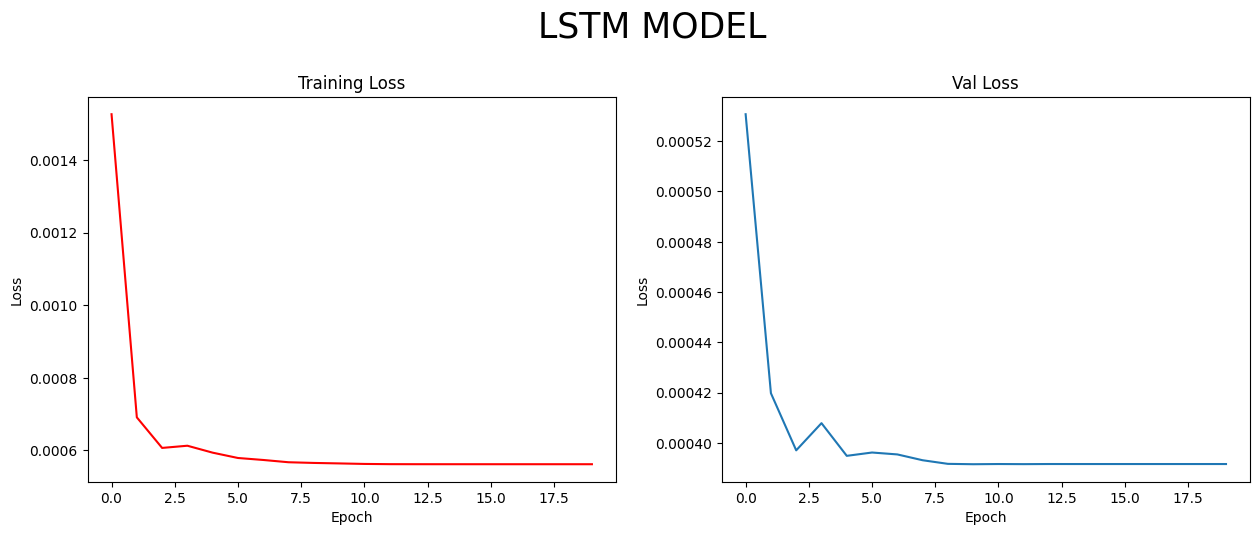

					FINAL LOSS: 0.00056 | FINAL MAE: 0.01378


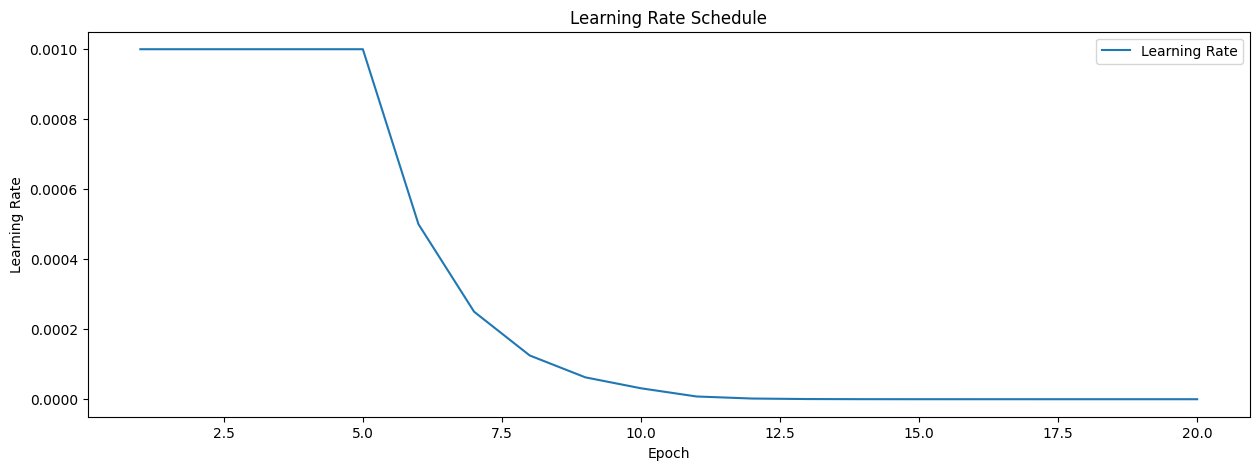

In [ ]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Val Loss')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 5),
                                                 round(lstm_history.history['mae'][-1] ,5)))

epochs = range(1, len(learning_rates) + 1)
plt.plot(epochs, learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [ ]:
test_pred=lstm_model.predict(test_data).reshape(-1)
y_test=[]
for inp,lab in test_data:
    y_test+=list(lab.numpy().reshape(-1))
print('Naive Model MAE:',np.abs(test_df['PM2.5'][24:].values - test_df['naive'][24:].values).sum()/len(test_df['PM2.5'][24:]))
print('LSTM Model MAE:',np.sum(np.abs(np.array(list(test_pred))-np.array(y_test)))/len(test_df))

35/35 [==============================] - 1s 8ms/step
Naive Model MAE: 0.02255334515872099
LSTM Model MAE: 0.008293057915321431


### Nueral Net Model with time transformed as features

#### Pre Processing

In [ ]:
df=pd.read_csv('Pollution_data.csv')
pollutant='PM2.5'
station_name=df['siteName'].unique()[0]
df['from date']=pd.to_datetime(df['from date'])
df['mins']=df['from date'].dt.minute
df=df[df['mins']==0].reset_index()[['from date',pollutant]] # Converted to Hourly dataframe
display(df.head())
print('Converted to Hourly Data from 15 min data')
timestamp_s =pd.to_datetime(df['from date']).map(datetime.datetime.timestamp)
day=24 * 60 * 60
year=365.25*day

df['day_sin']=np.sin(timestamp_s*2*np.pi/(day))
df['day_cos']=np.cos(timestamp_s*2*np.pi/(day))
df['year_sin']=np.sin(timestamp_s*2*np.pi/(year))
df['year_cos']=np.cos(timestamp_s*2*np.pi/(year))

#df['year']=df['from date'].dt.year
#df=df[[pollutant]]
df=df[['day_sin','day_cos','year_sin','year_cos',pollutant]]
#df=df[(df.year==2020)|(df.year==2021)][['from date',pollutant]].reset_index(drop=True)
#df=df[(df.year==2020)][['from date',pollutant]].reset_index(drop=True)
print(f'NaN Percentage : {df[pollutant].isna().sum()/len(df)*100 :.2f} %')
print("\nFilling Missing Values using Linear Interpolation")
print("Processing...")
# Lets Fill Missing Values with Linear Interpolation
df[pollutant]=linear_int(df[pollutant])
print("Finished Interpolation")

df.head()

,from date,PM2.5
0,2018-09-13 12:00:00,20.0
1,2018-09-13 13:00:00,24.0
2,2018-09-13 14:00:00,25.0
3,2018-09-13 15:00:00,27.0
4,2018-09-13 16:00:00,27.0


Converted to Hourly Data from 15 min data
NaN Percentage : 2.77 %

Filling Missing Values using Linear Interpolation
Processing...
Finished Interpolation


,day_sin,day_cos,year_sin,year_cos,PM2.5
0,0.991445,-0.130526,-0.948885,-0.315622,20.0
1,0.923880,-0.382683,-0.949111,-0.314942,24.0
2,0.793353,-0.608761,-0.949337,-0.314261,25.0
3,0.608761,-0.793353,-0.949562,-0.313581,27.0
4,0.382683,-0.923880,-0.949786,-0.312900,27.0


In [ ]:
# Splitting and Scaling
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

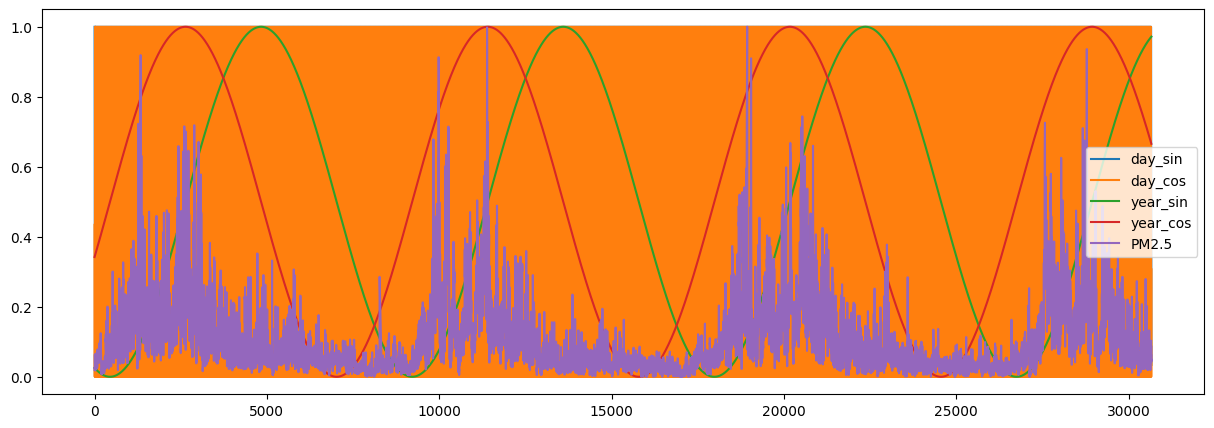

In [ ]:
train_df.plot()
plt.show()

#### Modelling

In [ ]:
df

,day_sin,day_cos,year_sin,year_cos,PM2.5
0,0.991445,-0.130526,-0.948885,-0.315622,20.0
1,0.923880,-0.382683,-0.949111,-0.314942,24.0
2,0.793353,-0.608761,-0.949337,-0.314261,25.0
3,0.608761,-0.793353,-0.949562,-0.313581,27.0
4,0.382683,-0.923880,-0.949786,-0.312900,27.0
...,...,...,...,...,...
43795,0.382683,0.923880,-0.940669,-0.339325,40.0
43796,0.608761,0.793353,-0.940912,-0.338650,38.0
43797,0.793353,0.608761,-0.941155,-0.337976,20.0
43798,0.923880,0.382683,-0.941397,-0.337301,20.0


In [ ]:
def create_dataset_ts(df,window,inp_len):
    inp_list=[]
    out=[]
    pbar = tqdm(total=len(df)-window)
    for ind,row in df[window:].iterrows():
        inp=[]
        inp.append(row['day_sin'])
        inp.append(row['day_cos'])
        inp.append(row['year_sin'])
        inp.append(row['year_cos'])
        for i in range(ind-window,ind):
            inp.append(df.loc[i]['PM2.5'])
        inp_list.append(inp)
        out.append(row['PM2.5'])
        pbar.update(1)
    inp_list=np.array(inp_list)
    out=np.array(out)

    inp_list=np.reshape(inp_list,(inp_list.shape[0],1,inp_list.shape[1]))
    return  inp_list,out


In [ ]:
inp,out=create_dataset_ts(train_df,25,24)
inp_val,out_val=create_dataset_ts(val_df,25,24)
inp_test,out_test=create_dataset_ts(test_df,25,24)
inp.shape,out.shape

100%|██████████| 4355/4355 [00:05<00:00, 832.41it/s]


((30634, 1, 29), (30634,))

In [ ]:
inp_val,out_val=create_dataset_ts(val_df,25,24)
inp_test,out_test=create_dataset_ts(test_df,25,24)

100%|██████████| 4355/4355 [00:05<00:00, 833.76it/s]


In [ ]:
lstm_model = Sequential([
    Dense(256, activation='relu',input_shape=(inp_val.shape[1], inp_val.shape[2])),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512, activation='relu',input_shape=(inp_val.shape[1], inp_val.shape[2])),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1024, activation='relu',input_shape=(inp_val.shape[1], inp_val.shape[2])),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512, activation='relu',input_shape=(inp_val.shape[1], inp_val.shape[2])),
    Dense(1),
])
lstm_model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['mae']
)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1, 256)            7680      
                                                                 
 batch_normalization_3 (Batc  (None, 1, 256)           1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1, 256)            0         
                                                                 
 dense_10 (Dense)            (None, 1, 512)            131584    
                                                                 
 batch_normalization_4 (Batc  (None, 1, 512)           2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)           

In [ ]:
def scheduler(epoch, lr):
  return lr * 0.5**(epoch//5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,mode='min')
  

In [ ]:
learning_rates = []  # To store learning rates

def record_lr(epoch, lr):
    learning_rates.append(lr)

record_lr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: record_lr(epoch, lstm_model.optimizer.lr.numpy()))

lstm_history = lstm_model.fit(
    x=inp,y=out,
    epochs=100,
    callbacks=[early_stopping,record_lr_callback,lr_scheduler],
    validation_data=[inp_val,out_val],
    shuffle=True,
    batch_size=128
    #verbose=1
)

Epoch 1/100
240/240 [==============================] - 16s 57ms/step - loss: 16.7445 - mae: 0.9997 - val_loss: 0.0160 - val_mae: 0.0970 - lr: 0.0100
Epoch 2/100
240/240 [==============================] - 9s 37ms/step - loss: 0.0460 - mae: 0.1501 - val_loss: 0.0097 - val_mae: 0.0775 - lr: 0.0100
Epoch 3/100
240/240 [==============================] - 10s 40ms/step - loss: 0.0249 - mae: 0.1152 - val_loss: 0.0085 - val_mae: 0.0741 - lr: 0.0100
Epoch 4/100
240/240 [==============================] - 13s 52ms/step - loss: 0.0186 - mae: 0.1013 - val_loss: 0.0134 - val_mae: 0.0869 - lr: 0.0100
Epoch 5/100
240/240 [==============================] - 12s 49ms/step - loss: 0.0176 - mae: 0.0982 - val_loss: 0.0111 - val_mae: 0.0864 - lr: 0.0100
Epoch 6/100
240/240 [==============================] - 14s 60ms/step - loss: 0.0149 - mae: 0.0902 - val_loss: 0.0069 - val_mae: 0.0671 - lr: 0.0050
Epoch 7/100
240/240 [==============================] - 14s 57ms/step - loss: 0.0141 - mae: 0.0874 - val_loss: 0.

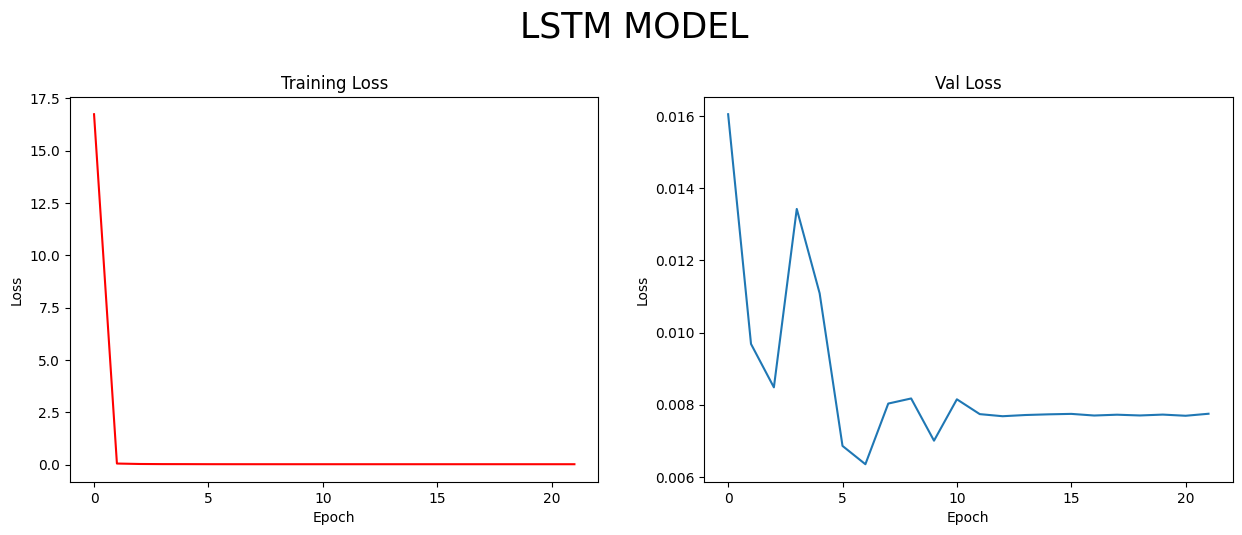

					FINAL LOSS: 0.01346 | FINAL MAE: 0.08502


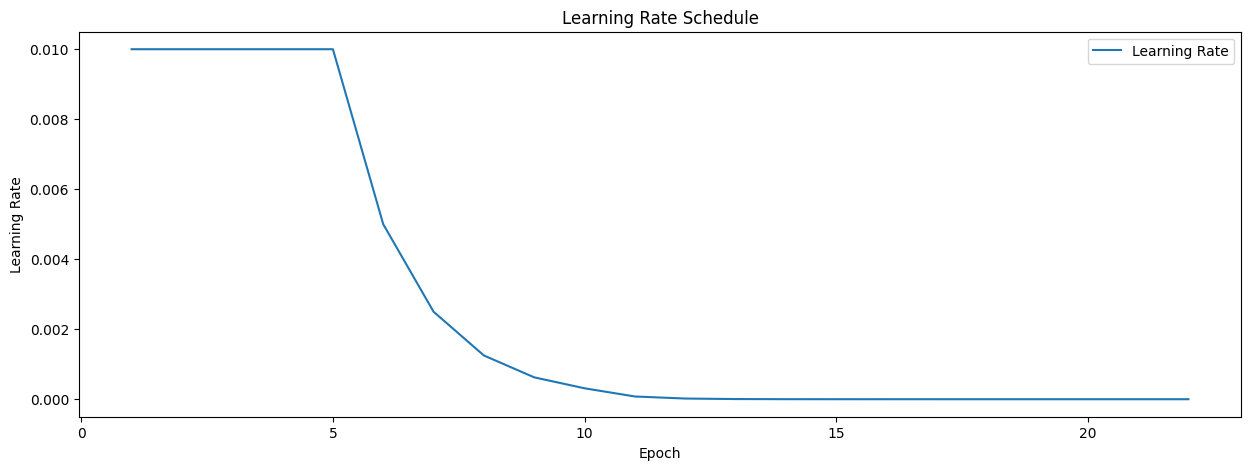

In [ ]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Val Loss')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 5),
                                                 round(lstm_history.history['mae'][-1] ,5)))

epochs = range(1, len(learning_rates) + 1)
plt.plot(epochs, learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [ ]:
test_pred_2=lstm_model.predict(inp_test).reshape(-1)
print('Naive Model MAE:',np.abs(test_df['PM2.5'][24:].values - naive).sum()/len(test_df['PM2.5'][24:]))
print('Simple LSTM Model MAE:',np.sum(np.abs(np.array(list(test_pred))-np.array(y_test)))/len(test_df))
print('LSTM with time featues Model MAE:',np.sum(np.abs(np.array(list(test_pred_2))-np.array(out_test)))/len(test_df))


137/137 [==============================] - 2s 9ms/step
Naive Model MAE: 0.02255334515872099
Simple LSTM Model MAE: 0.008293057915321431
LSTM with time featues Model MAE: 0.07192601110316599
